In [1]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio

Found existing installation: torch 2.10.0
Uninstalling torch-2.10.0:
  Successfully uninstalled torch-2.10.0
Found existing installation: torchvision 0.25.0
Uninstalling torchvision-0.25.0:
  Successfully uninstalled torchvision-0.25.0
Found existing installation: torchaudio 2.10.0
Uninstalling torchaudio-2.10.0:
  Successfully uninstalled torchaudio-2.10.0
  Using cached torch-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (31 kB)
  Using cached torchvision-0.25.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (5.4 kB)
  Using cached torchaudio-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (6.9 kB)
Using cached torch-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl (915.7 MB)
Using cached torchvision-0.25.0-cp312-cp312-manylinux_2_28_x86_64.whl (8.1 MB)
Using cached torchaudio-2.10.0-cp312-cp312-manylinux_2_28_x86_64.whl (1.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

Device: cuda
Samples: 419509
Training started...
Epoch 0 | D Loss: 1.3823 | G Loss: 0.6910
Epoch 400 | D Loss: 1.3602 | G Loss: 0.7218
Epoch 800 | D Loss: 1.4151 | G Loss: 0.6859
Epoch 1200 | D Loss: 1.3520 | G Loss: 0.7184
Epoch 1600 | D Loss: 1.3568 | G Loss: 0.7300


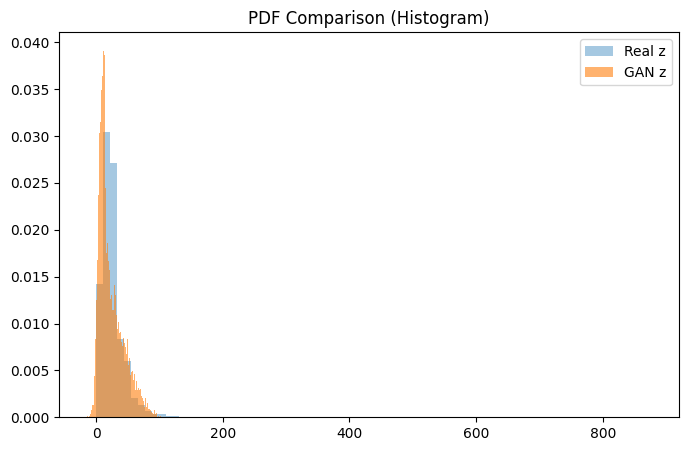

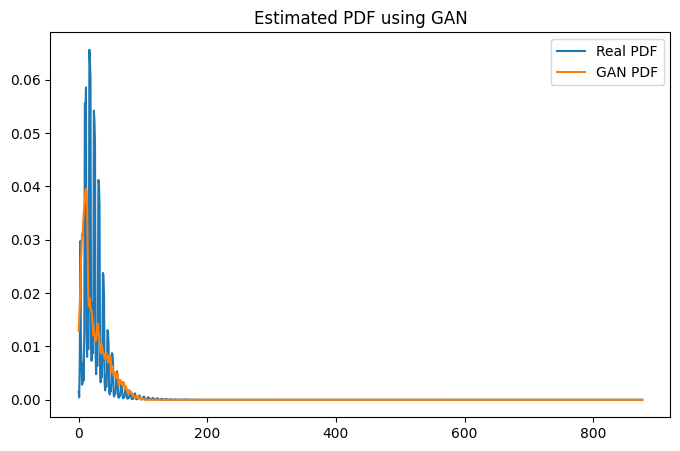

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
df = pd.read_csv("data.csv", encoding="latin1", low_memory=False)
x = pd.to_numeric(df["no2"], errors="coerce").dropna().values.astype(np.float32)
print("Samples:", len(x))

r = 102303927
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

z = x + a_r * np.sin(b_r * x)
z_mean = z.mean()
z_std = z.std()
z_norm = (z - z_mean) / z_std

z_tensor = torch.tensor(z_norm, dtype=torch.float32).view(-1, 1).to(device)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
g_opt = optim.Adam(G.parameters(), lr=0.0002)
d_opt = optim.Adam(D.parameters(), lr=0.0002)

epochs = 2000
batch_size = 128
print("Training started...")

for epoch in range(epochs):
    idx = torch.randint(0, z_tensor.size(0), (batch_size,))
    real = z_tensor[idx]

    noise = torch.randn(batch_size, 1, device=device)
    fake = G(noise).detach()

    real_labels = torch.ones(batch_size, 1, device=device)
    fake_labels = torch.zeros(batch_size, 1, device=device)
    d_loss = criterion(D(real), real_labels) + criterion(D(fake), fake_labels)
    d_opt.zero_grad()
    d_loss.backward()
    d_opt.step()

    noise = torch.randn(batch_size, 1, device=device)
    fake = G(noise)
    g_loss = criterion(D(fake), real_labels)

    g_opt.zero_grad()
    g_loss.backward()
    g_opt.step()

    if epoch % 400 == 0:
        print(f"Epoch {epoch} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

G.eval()
with torch.no_grad():
    noise = torch.randn(10000, 1, device=device)
    gen_z = G(noise).cpu().numpy()

gen_z = gen_z * z_std + z_mean

plt.figure(figsize=(8, 5))
plt.hist(z, bins=80, density=True, alpha=0.4, label="Real z")
plt.hist(gen_z, bins=80, density=True, alpha=0.6, label="GAN z")
plt.legend()
plt.title("PDF Comparison (Histogram)")
plt.show()
kde_real = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(z.reshape(-1, 1))
kde_gen = KernelDensity(kernel="gaussian", bandwidth=0.5).fit(gen_z.reshape(-1, 1))

z_range = np.linspace(z.min(), z.max(), 1000).reshape(-1, 1)

plt.figure(figsize=(8, 5))
plt.plot(z_range, np.exp(kde_real.score_samples(z_range)), label="Real PDF")
plt.plot(z_range, np.exp(kde_gen.score_samples(z_range)), label="GAN PDF")
plt.legend()
plt.title("Estimated PDF using GAN")
plt.show()